# Emtionserkennung auf Gesichter mit selbst trainiertem CNN (VGG16)
#### Finetuning von Hyperparameter
# Test mit neuen Bildern und pretrained Haar Style Cascades für die bounding box der Gesichter

Nach https://colab.research.google.com/github/amankrpandey1/face-emotion-detection-using-cnn-and-opencv/blob/main/emotion_detection.ipynb von Aman Pandey, Bhopal, India.

# Introduction

Humans communicate using facial expressions as well as other body language and verbal cues. Researchers are using deep learning approaches in artificial intelligence research as a way to help make decisions. They need to study people in order to predict how they'll respond or know what they're feeling. This study proposes the development of a system that predicts and classifies facial emotions by using the Convolution Neural Network algorithm, among other features.

Data preprocessing, facial feature extraction, and facial emotion classification are the three key steps in this notebook. Facial expressions were predicted with 62.66% accuracy using the Convolutional Neural Network (CNN). This algorithm was evaluated on a database from [FER2013](https://https://www.kaggle.com/datasets/deadskull7/fer2013) database, which has **35887 48x48** grayscale images representing each of the emotions.

<br>

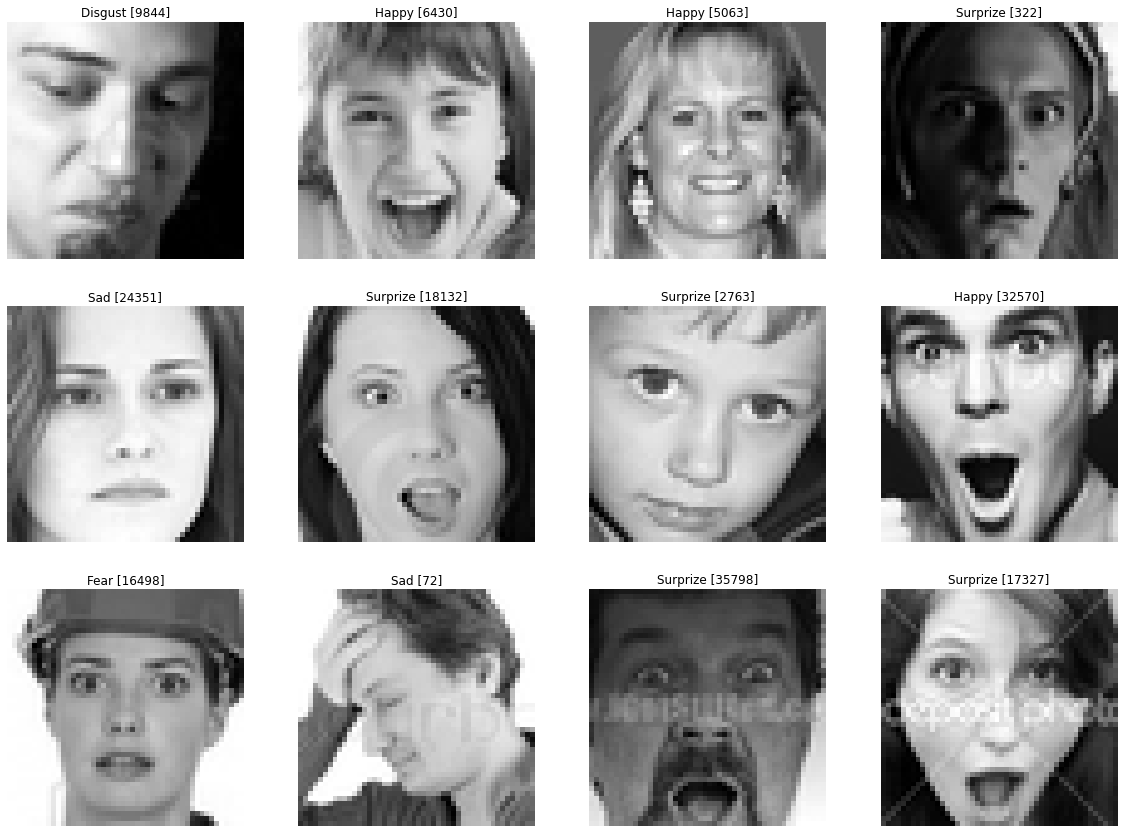

##Here we are also going to use OpenCV for the webcam and model deployement.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

ModuleNotFoundError: No module named 'tensorflow.keras.applica'

In [3]:
df = pd.read_csv('fer2013.csv') 

print(df.shape  )
display(df.head(5))

# Reduziere die Anzahl der Daten auf eine zufällige Stichprobe
df = df.sample(n=10000, random_state=42)


(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Exploratory Data Analysis



In [3]:
print("Null values present in the file:",df.isna().sum().sum())
print("Basic information about the dataframe:")
df.info()

df.describe()

Null values present in the file: 0
Basic information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 19098 to 27329
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  2000 non-null   int64 
 1   pixels   2000 non-null   object
 2   Usage    2000 non-null   object
dtypes: int64(1), object(2)
memory usage: 62.5+ KB


,emotion
count,2000.000000
mean,3.276000
std,1.916419
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [2]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

#### No of images present in dataset corresponding to each emotion

In [5]:
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,303,Angry
1,27,Disgust
2,297,Fear
3,491,Happy
4,297,Sad
5,240,Surprize
6,345,Neutral


#### No of images present in training testing and validation part

In [6]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,181
PublicTest,195
Training,1624


##Visualizing images from the dataset

# Data Preprocessing

#### Extracting rows for each part

In [4]:
# Im Original wurde langsames append verwendet. Von copilot  auf numpy arrays geändert.

# Initialisiere leere Listen für die Daten
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

# Konvertiere die Spalten 'pixels' und 'emotion' in NumPy-Arrays
pixels = df['pixels'].apply(lambda x: np.array(x.split(" "), dtype='float'))
emotions = df['emotion'].values

# Verwende Masken, um die Daten nach 'Usage' zu filtern
train_mask = df['Usage'] == 'Training'
test_mask = df['Usage'] == 'PrivateTest'
val_mask = df['Usage'] == 'PublicTest'

# Weise die gefilterten Daten den entsprechenden Arrays zu
X_train = pixels[train_mask].values
y_train = emotions[train_mask]
X_test = pixels[test_mask].values
y_test = emotions[test_mask]
X_val = pixels[val_mask].values
y_val = emotions[val_mask]

# Konvertiere die Listen in NumPy-Arrays
X_train = np.array(X_train.tolist())
y_train = np.array(y_train)
X_test = np.array(X_test.tolist())
y_test = np.array(y_test)
X_val = np.array(X_val.tolist())
y_val = np.array(y_val)


In [5]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((7995, 2304), (7995,), (1005, 2304), (1005,), (1000, 2304), (1000,))

#### change the shape of the images 

In [6]:
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0],48,48,1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)

y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)
y_val = to_categorical(y_val,num_classes=7)

X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((7995, 48, 48, 1),
 (7995, 7),
 (1005, 48, 48, 1),
 (1005, 7),
 (1000, 48, 48, 1),
 (1000, 7))

# Defining Model Architecture VGG16

In [7]:
def cnn_model():
  model = Sequential()

  model.add(ZeroPadding2D((1,1),input_shape=(48,48,1),name="block1_pad1"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l1"))
  model.add(ZeroPadding2D((1,1),name="block1_pad2"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool1"))

  model.add(ZeroPadding2D((1,1),name="block2_pad1"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_l1"))
  model.add(ZeroPadding2D((1,1),name="block2_l2"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_pad2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool2"))

  model.add(ZeroPadding2D((1,1),name="block3_pad1"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l1"))
  model.add(ZeroPadding2D((1,1),name="block3_pad2"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l2"))
  model.add(ZeroPadding2D((1,1),name="block3_pad3"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool3"))

  model.add(ZeroPadding2D((1,1),name="block4_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l1"))
  model.add(ZeroPadding2D((1,1),name="block4_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l2"))
  model.add(ZeroPadding2D((1,1),name="block4_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool4"))


  model.add(ZeroPadding2D((1,1),name="block5_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l1"))
  model.add(ZeroPadding2D((1,1),name="block5_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l2"))
  model.add(ZeroPadding2D((1,1), name="block5_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool5"))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu',name="block6"))
  model.add(Dropout(0.5,name="drop1"))
  model.add(Dense(4096, activation='relu',name="block7"))
  model.add(Dropout(0.5,name="drop2"))
  model.add(Dense(7, activation='softmax',name="block8"))

  return model

In [8]:
model = cnn_model()
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\reshaping\zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_pad1 (ZeroPadding2D)          │ (None, 50, 50, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_l1 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pad2 (ZeroPadding2D)          │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_l2 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1 (MaxPooling2D)                 │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pad1 (ZeroPadding2D)          │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_l1 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_l2 (ZeroPadding2D)            │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pad2 (Conv2D)                 │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2 (MaxPooling2D)                 │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad1 (ZeroPadding2D)          │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l1 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad2 (ZeroPadding2D)          │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l2 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pad3 (ZeroPadding2D)          │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_l3 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool3 (MaxPooling2D)                 │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pad1 (ZeroPadding2D)          │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_l1 (Conv2D)                   │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pad2 (ZeroPadding2D)          │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_l2 (Conv2D)                   │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 33,624,775 (128.27 MB)

 Trainable params: 33,624,775 (128.27 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('Face_Emotion_Detect_VGG16.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]
# erste Versuche zeigen zu frühren stop nach 11 Epochen

history = model.fit(
    X_train,
    y_train,
    batch_size=128,  # 128 für alle Bilder, oroginal 32
    epochs=50,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2257 - loss: 1.8754
Epoch 1: val_accuracy improved from -inf to 0.24300, saving model to Face_Emotion_Detect_VGG16.h5


63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.2259 - loss: 1.8751 - val_accuracy: 0.2430 - val_loss: 1.8284
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2407 - loss: 1.8342
Epoch 2: val_accuracy did not improve from 0.24300
63/63 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.2408 - loss: 1.8342 - val_accuracy: 0.2430 - val_loss: 1.8230
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2386 - loss: 1.8277
Epoch 3: val_accuracy did not improve from 0.24300
63/63 ━━━━━━━━━━━━━━━━━━━━ 410s 7s/step - accuracy: 0.2387 - loss: 1.8277 - val_accuracy: 0.2430 - val_loss: 1.8202
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2534 - loss: 1.8205
Epoch 4: val_accuracy did not improve from 0.24300
63/63 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.2533 - loss: 1.8205 - val_accuracy: 0.2430 - val_loss: 1.8164
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2482 - loss: 1.8143
Epoch 5: val_accuracy did not improve from 0.24300


KeyboardInterrupt: 

# Model Evaluation

Experiment mit 2000 Bilder von fer213.csv
Wenn das Modell zu kurz (3 Lernepochen) trainiert wird, dann wird nur die Mehrheitsklasse erkannt.
eearly stopping greift bei 11. Epoche zu, acc_train geht zwar auf 0,99 hoch, val_acc geht aber nicht höher als 0,53 in 11., 0,44 in 17.
ca 30 Sek,/Epoche

Experiment mit 10000  Bildern
ca 120 bis 400 Sek,/Epoche

Experiment mit allen 36000  Bildern  -> mit CPU zu langsam!
50 Lernepochen

Lets see the output resutls 
* Loss plot
* Images with their predicted vs actual label
* Confusion Matrix
* Classification Reprot

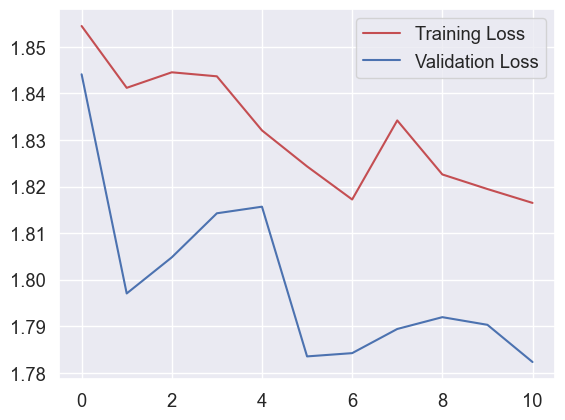

In [34]:
# 
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

In [14]:
# Model Inference
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step


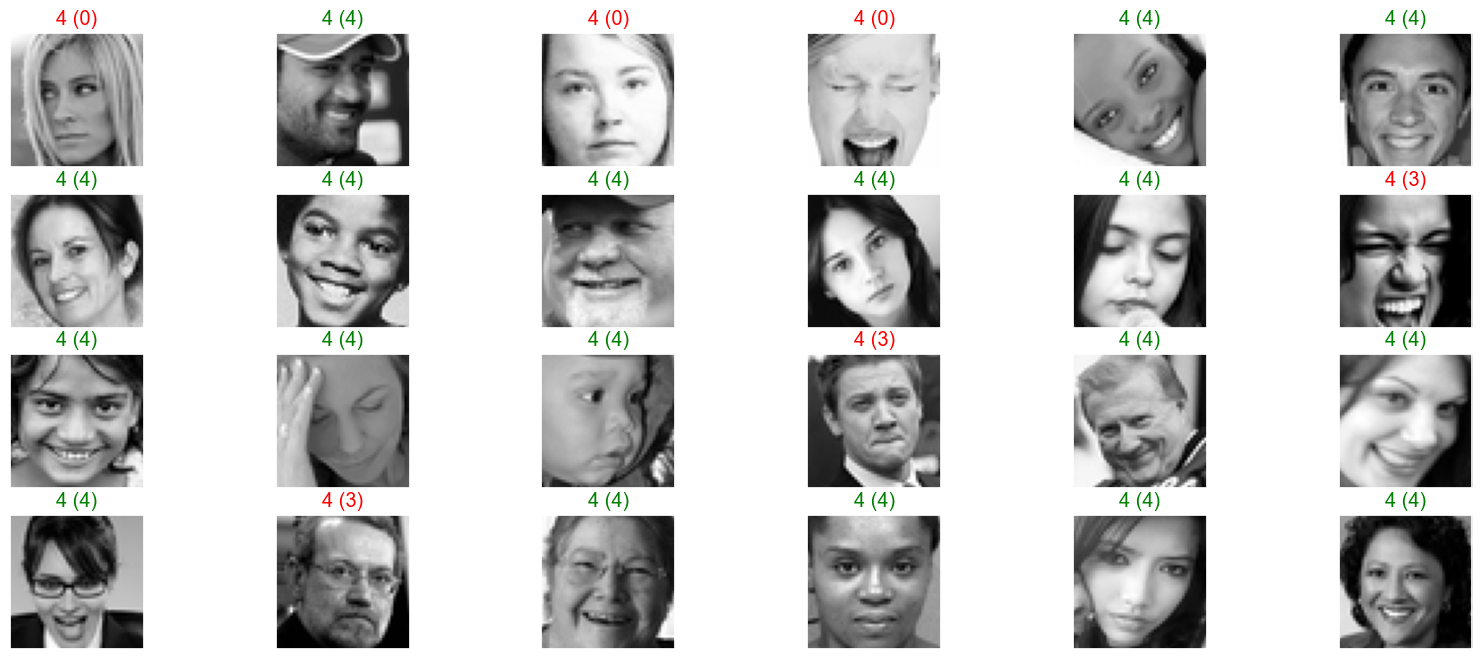

In [35]:
# im original sind die vaules durch emontion keys ersetzt
#function to plot images with their lables(actual vs predicted)
def check_images(X_test,y_pred,label_dict={}):

  figure = plt.figure(figsize=(20, 8))
  for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
      ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(X_test[index]),cmap="gray")
      predict_index = label_dict[(y_pred[index])]
      true_index = label_dict[np.argmax(y_test,axis=1)[index]]
      ax.set_title("{} ({})".format((predict_index),
                                    (true_index)),
                                    color=("green" if predict_index == true_index else "red"))
      
check_images(X_test,y_pred,emotions)

In [36]:
# function to plot confusion matrix
def conf_mat(y_test,y_pred,labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]):
  CLASS_LABELS  = labels
  cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (12,6))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.set(font_scale=1.2)
  ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

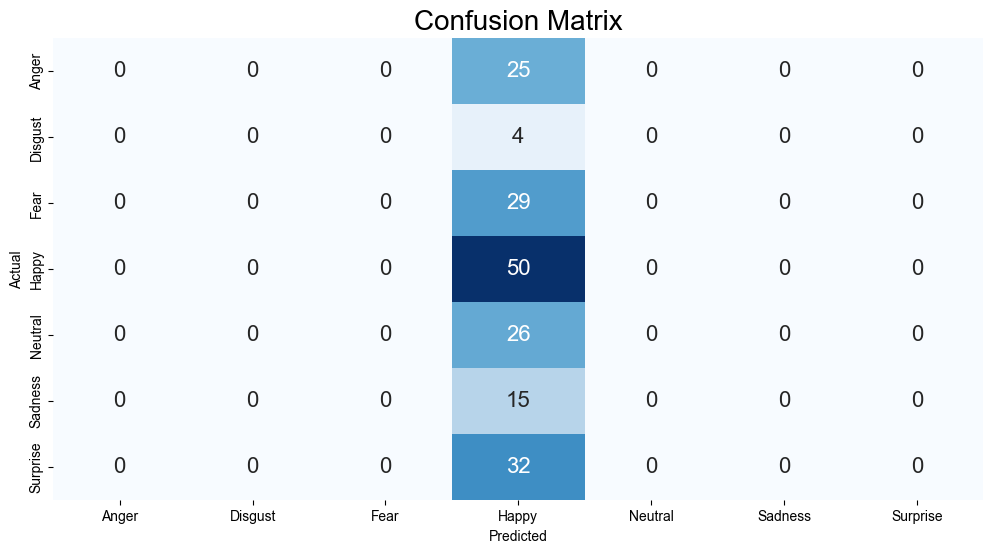

In [17]:
conf_mat(y_test,y_pred)

In [18]:
#classification report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        25
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000        29
           3      0.276     1.000     0.433        50
           4      0.000     0.000     0.000        26
           5      0.000     0.000     0.000        15
           6      0.000     0.000     0.000        32

    accuracy                          0.276       181
   macro avg      0.039     0.143     0.062       181
weighted avg      0.076     0.276     0.120       181



C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [37]:
 # loss and accuracy
loss_and_metrics = model.evaluate(X_train,y_train)
print("On Training Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_val,y_val)
print("On Validation Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_test,y_test)
print("On Test Data",loss_and_metrics)


51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.2435 - loss: 1.8442
On Training Data [1.848214030265808, 0.24137930572032928]
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.2534 - loss: 1.8445
On Validation Data [1.8441160917282104, 0.25128206610679626]
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.2523 - loss: 1.8676
On Test Data [1.8516610860824585, 0.27624309062957764]


# Fine Tuning

Let's try to improve the model

#### 1. Changing epoch, learning rate and batch size

In [20]:
model = cnn_model()
model.compile(optimizer=SGD(learning_rate=0.005),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=2,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)


C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\reshaping\zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2019 - loss: 1.9150
Epoch 1: val_accuracy did not improve from 0.25128
26/26 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2024 - loss: 1.9141 - val_accuracy: 0.2513 - val_loss: 1.8367
Epoch 2/2
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2168 - loss: 1.8548
Epoch 2: val_accuracy did not improve from 0.25128
26/26 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2171 - loss: 1.8546 - val_accuracy: 0.2513 - val_loss: 1.8098
Restoring model weights from the end of the best epoch: 1.


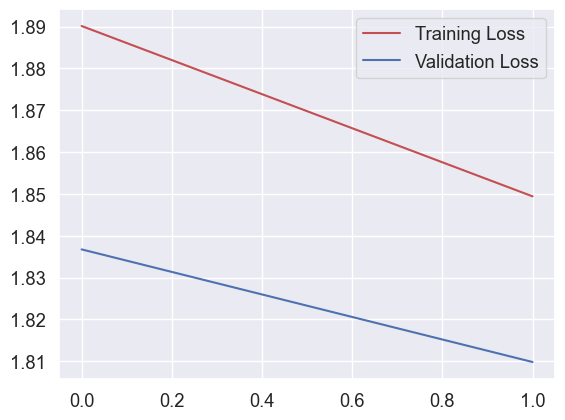

In [21]:
loss_plot(history)

In [22]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        25
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000        29
           3      0.276     1.000     0.433        50
           4      0.000     0.000     0.000        26
           5      0.000     0.000     0.000        15
           6      0.000     0.000     0.000        32

    accuracy                          0.276       181
   macro avg      0.039     0.143     0.062       181
weighted avg      0.076     0.276     0.120       181



C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### 2. Changing optimizer

In [38]:
model = cnn_model()
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)


C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\reshaping\zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2183 - loss: 1.8701
Epoch 1: val_accuracy did not improve from 0.25128
26/26 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.2187 - loss: 1.8695 - val_accuracy: 0.2513 - val_loss: 1.8236
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2354 - loss: 1.8388
Epoch 2: val_accuracy did not improve from 0.25128
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2354 - loss: 1.8389 - val_accuracy: 0.2513 - val_loss: 1.8206
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1828 - loss: 1.8471
Epoch 3: val_accuracy did not improve from 0.25128
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.1839 - loss: 1.8468 - val_accuracy: 0.2513 - val_loss: 1.8198
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2511 - loss: 1.8283
Epoch 4: val_accuracy did not improve from 0.25128
26/26 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2507 - loss: 1.8285 - val_accuracy: 0.2513 - val_loss: 1.8021
Epoc

26/26 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2332 - loss: 1.8047 - val_accuracy: 0.2615 - val_loss: 1.9084
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2923 - loss: 1.7592
Epoch 9: val_accuracy improved from 0.26154 to 0.27692, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.2922 - loss: 1.7582 - val_accuracy: 0.2769 - val_loss: 1.6978
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3073 - loss: 1.7066
Epoch 10: val_accuracy improved from 0.27692 to 0.34359, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.3076 - loss: 1.7059 - val_accuracy: 0.3436 - val_loss: 1.6213
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3370 - loss: 1.6106
Epoch 11: val_accuracy improved from 0.34359 to 0.42564, saving model to best_model.h5


26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3371 - loss: 1.6111 - val_accuracy: 0.4256 - val_loss: 1.5801
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3845 - loss: 1.5558
Epoch 12: val_accuracy did not improve from 0.42564
26/26 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.3843 - loss: 1.5558 - val_accuracy: 0.3590 - val_loss: 1.5963
Epoch 13/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.3858 - loss: 1.4974
Epoch 13: val_accuracy did not improve from 0.42564
26/26 ━━━━━━━━━━━━━━━━━━━━ 190s 8s/step - accuracy: 0.3865 - loss: 1.4966 - val_accuracy: 0.4103 - val_loss: 1.7023
Epoch 14/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4560 - loss: 1.3712
Epoch 14: val_accuracy did not improve from 0.42564
26/26 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4552 - loss: 1.3727 - val_accuracy: 0.3949 - val_loss: 1.5762
Epoch 15/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4787 - loss: 1.3089
Epoch 15: val_accuracy did not improve from 0.4

26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5083 - loss: 1.1920 - val_accuracy: 0.4821 - val_loss: 1.5983
Epoch 17/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5479 - loss: 1.0854
Epoch 17: val_accuracy did not improve from 0.48205
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5474 - loss: 1.0870 - val_accuracy: 0.4615 - val_loss: 1.5336
Epoch 18/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5485 - loss: 1.1028
Epoch 18: val_accuracy did not improve from 0.48205
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5479 - loss: 1.1044 - val_accuracy: 0.4308 - val_loss: 1.5715
Epoch 19/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5897 - loss: 1.0285
Epoch 19: val_accuracy did not improve from 0.48205
26/26 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5899 - loss: 1.0274 - val_accuracy: 0.3897 - val_loss: 1.7973
Epoch 20/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6424 - loss: 0.8575
Epoch 20: val_accuracy did not improve from 0.48

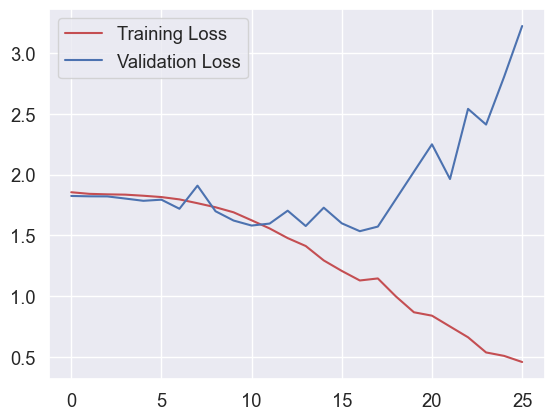

In [39]:
loss_plot(history)

In [25]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000        25
           1      0.000     0.000     0.000         4
           2      0.000     0.000     0.000        29
           3      0.276     1.000     0.433        50
           4      0.000     0.000     0.000        26
           5      0.000     0.000     0.000        15
           6      0.000     0.000     0.000        32

    accuracy                          0.276       181
   macro avg      0.039     0.143     0.062       181
weighted avg      0.076     0.276     0.120       181



C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


###### Observation

If the model is getting overfitted by the data and the same arch. is not giving better results after tuning.
More steps that can be taken to improve the performance
1. Adding regularization in the model Arch.
2. Adding more data in validation set
3. Try with diff cnn arch

#### Model Saving

In [31]:
model_json = model.to_json()
with open("Face_Emotion_Detect_VGG16.json", "w") as json_file:
  json_file.write(model_json)
model.save_weights("Face_Emotion_Detect_VGG16.weights.h5")
print("Saved model to disk")

Saved model to disk


#### Deploying model using OpenCV and the saved model

Note: Run the below code in your local machine

In [32]:
## loading model arch and weights
model = model_from_json(open("Face_Emotion_Detect_VGG16.json", "r").read())
model.load_weights('Face_Emotion_Detect_VGG16.weights.h5')


## Emotion eines Testbildes erkennen

pretrained haar style detection zur Umrahmung eines Gesichtes und VGG16 zur Klassifikation der Emotion.
unter Linux zb /usr/local/lib/python3.9/dist-packages/cv2/data/haarcascade_frontalface_default.xml enthält die Modelldaten

(Webcam code aus dem Original entfernt.)

Bild geladen.


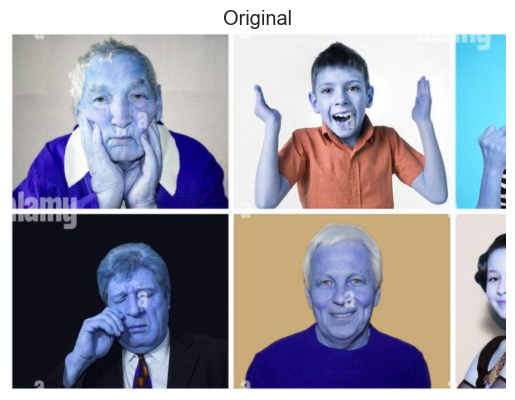

Bild in Graustufen konvertiert.
False
Face Haar-Cascade-Classifier haarcascade_frontalface_default.xml geladen.
Haar-Cascade-Classifier erfolgreich überprüft.
4 Gesichter erkannt.
Gesicht erkannt bei x: 557, y: 57, Breite: 124, Höhe: 124


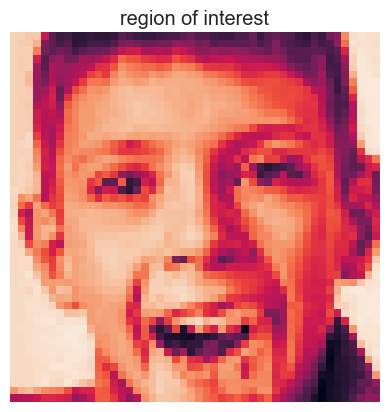

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Emotion erkannt : surprise
Gesicht erkannt bei x: 551, y: 416, Breite: 133, Höhe: 133


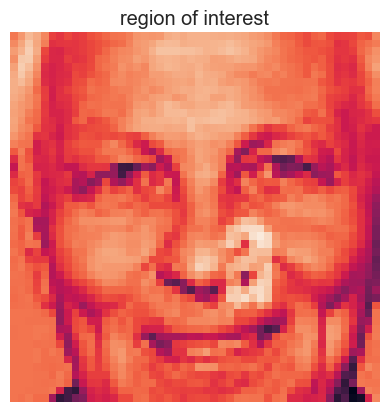

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Emotion erkannt : happy
Gesicht erkannt bei x: 180, y: 440, Breite: 131, Höhe: 131


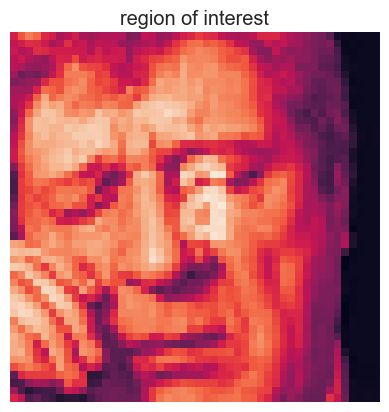

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Emotion erkannt : neutral
Gesicht erkannt bei x: 115, y: 53, Breite: 178, Höhe: 178


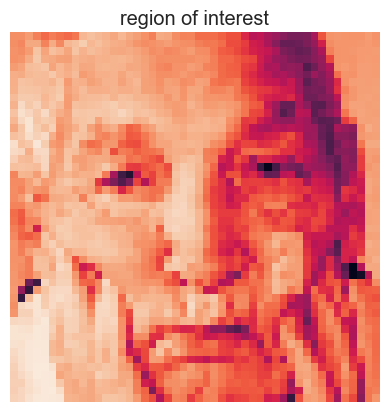

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Emotion erkannt : angry
Ergebnisbild verkleinert.


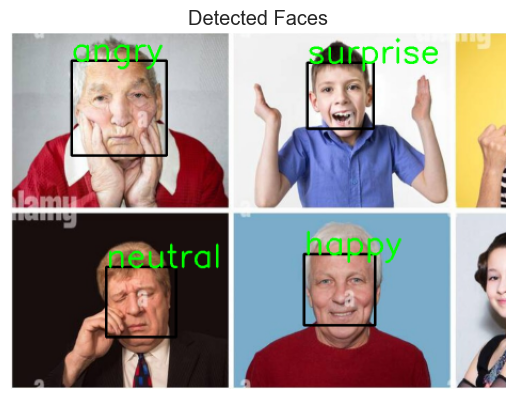

Ergebnis inline im Notebook angezeigt.


In [52]:
# 
# w

face_haar_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

# Lade das TestBild
test_image = cv2.imread(r"WilliHahn_Foto.jpg")
test_image = cv2.imread(r"Gesichter4xEmotion.jpg")
if test_image is None:
    raise IOError('Bilddatei nicht gefunden oder konnte nicht geöffnet werden')
print("Bild geladen.")
plt.imshow(test_image)
plt.title('Original')
plt.axis('off')  # Achsen ausblenden
plt.show()
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
print("Bild in Graustufen konvertiert.")


import os
print(os.path.exists('haarcascade_frontalface_default.xml'))


# Lade den pretained Haar-Cascade-Classifier von openCV
printf"pretained Haar-Cascade-Classifier in Verzeichis: {cv2.data.haarcascades}
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
print("Face Haar-Cascade-Classifier haarcascade_frontalface_default.xml geladen.")

# Überprüfe, ob der CascadeClassifier korrekt geladen wurde
if face_haar_cascade.empty():
    raise IOError('Haarcascade XML file not found or invalid')
print("Haar-Cascade-Classifier erfolgreich überprüft.")

# V1 # Führe die Gesichtserkennung durch
# V1 faces = haar_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
# V1 print(f"{len(faces)} Gesichter erkannt.")
# V1 
# V1 
# V1 # Zeichne Rechtecke um erkannte Gesichter und drucke die Koordinaten
# V1 print(f"Bildauflösung: Breite: {img.shape[1]}, Höhe: {img.shape[0]}")
# V1 for (x, y, w, h) in faces:
# V1    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
# V1    print(f"Gesicht erkannt bei x: {x}, y: {y}, Breite: {w}, Höhe: {h}")


faces_detected = face_haar_cascade.detectMultiScale(gray_image) #detecting faces from the image using haar_cascade
print(f"{len(faces_detected)} Gesichter erkannt.")
for (x,y,w,h) in faces_detected: #cordinates of deteced faces
        cv2.rectangle(test_image,(x,y), (x+w,y+h), (0, 0, 0), thickness=3) #putting a rectange box around detected face
        print(f"Gesicht erkannt bei x: {x}, y: {y}, Breite: {w}, Höhe: {h}")
        roi_gray=gray_image[y:y+w,x:x+h]  # capturing only face from the image
        roi_gray=cv2.resize(roi_gray,(48,48)) # resizing it to 48,48 (that's what mdodel wants as an input)
        plt.imshow(roi_gray)
        plt.title('region of interest')
        plt.axis('off')  # Achsen ausblenden
        plt.show()
        image_pixels = img_to_array(roi_gray) #converting image to array
        image_pixels = np.expand_dims(image_pixels, axis = 0) #expanding dims as model needs input in batches
        # image_pixels /= 255


        predictions = model.predict(image_pixels) #model prediction
        max_index = np.argmax(predictions[0]) #getting emotion index
        emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        emotion_prediction = emotion_detection[max_index]
        print(f"Emotion erkannt : {emotion_prediction}")

        cv2.putText(test_image, emotion_prediction, (int(x), int(y)),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3) #putting text on face
    #   cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)

# Verkleinere das Ergebnisbild
scale_percent = 50  # Prozentuale Verkleinerung
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

resized_img = cv2.resize(test_image, dim, interpolation=cv2.INTER_AREA)
print("Ergebnisbild verkleinert.")

# Konvertiere das Bild von BGR zu RGB
resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

# Zeige das Ergebnis inline im Notebook
plt.imshow(resized_img_rgb)
plt.title('Detected Faces')
plt.axis('off')  # Achsen ausblenden
plt.show()
print("Ergebnis inline im Notebook angezeigt.")


In [ ]:
#import cv2
#import numpy as np
#from keras.preprocessing.image import img_to_array
#import matplotlib.pyplot as plt

# Lade den Haar-Cascade-Classifier
# face_haar_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')  # lokal
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')  #openCV Repo
if face_haar_cascade.empty():
    raise IOError('Haarcascade XML file not found or invalid')
print("Haar-Cascade-Classifier erfolgreich geladen.")

# Lade das Bild
img = cv2.imread(r"WilliHahn_Foto.jpg")
if img is None:
    raise IOError('Bilddatei nicht gefunden oder konnte nicht geöffnet werden')
print("Bild geladen.")

gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print("Bild in Graustufen konvertiert.")

faces_detected = face_haar_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)
# Führe die Gesichtserkennung durch
print(f"{len(faces_detected)} Gesichter erkannt.")

# Zeichne Rechtecke um erkannte Gesichter und drucke die Koordinaten
print(f"Bildauflösung: Breite: {img.shape[1]}, Höhe: {img.shape[0]}")
for (x, y, w, h) in faces_detected:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    print(f"Gesicht erkannt bei x: {x}, y: {y}, Breite: {w}, Höhe: {h}")

    roi_gray = gray_image[y:y + h, x:x + w]  # capturing only face from the image
    roi_gray = cv2.resize(roi_gray, (48, 48))  # resizing it to 48x48 (that's what model wants as an input)
    image_pixels = img_to_array(roi_gray)  # converting image to array
    image_pixels = np.expand_dims(image_pixels, axis=0)  # expanding dims as model needs input in batches

    predictions = model.predict(image_pixels)  # model prediction
    max_index = np.argmax(predictions[0])  # getting emotion index
    emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    emotion_prediction = emotion_detection[max_index]

    cv2.putText(img, emotion_prediction, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)  # putting text around face

# Verkleinere das Ergebnisbild
scale_percent = 50  # Prozentuale Verkleinerung
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)

resized_img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
print("Ergebnisbild verkleinert.")

# Konvertiere das Bild von BGR zu RGB
resized_img_rgb = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)

# Zeige das Ergebnis inline im Notebook
plt.imshow(resized_img_rgb)
plt.title('Detected Faces')
plt.axis('off')  # Achsen ausblenden
plt.show()
print("Ergebnis inline im Notebook angezeigt.")
